# Single species single end library

In [93]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp
import pandas as pd
import skbio
import skbio.diversity
import pybedtools

In [3]:
plt.style.use('seaborn')
%matplotlib inline

### Dataset

CONFIGURATION (edit the following cell)

In [92]:
analysis_dir = Path('/Users/laserson/tmp/phip_analysis/phip-28/sc5314')
genome_gff = Path('/Users/laserson/refdata/genomes/cal/GCF_000182965.3_ASM18296v3_genomic.gff')

In [355]:
bam_file = analysis_dir / 'genome_aligned_reads.unsorted.bam'

fragment_file = analysis_dir / 'fragments.tsv'

cov_path = analysis_dir / 'coverage'

cov_genome_weighted_file = cov_path / 'genome.weighted.tsv'
cov_genome_dedup_file = cov_path / 'genome.dedup.tsv'

cov_unstranded_weighted_file = cov_path / 'unstranded.weighted.tsv'
cov_unstranded_dedup_file = cov_path / 'unstranded.dedup.tsv'

cov_stranded_weighted_file = cov_path / 'stranded.weighted.tsv'
cov_stranded_dedup_file = cov_path / 'stranded.dedup.tsv'

cov_inframe_weighted_file = cov_path / 'inframe.weighted.tsv'
cov_inframe_dedup_file = cov_path / 'inframe.dedup.tsv'

## Alignment

Number of raw reads

In [8]:
_ = !samtools view -c {bam_file}
raw_read_count = int(_[0])
raw_read_count

8752941

Number of genome-aligned reads

In [9]:
_ = !samtools view -c -F 4 {bam_file}
aligned_read_count = int(_[0])
aligned_read_count

7759014

Fraction of reads that map to species

In [10]:
aligned_read_count / raw_read_count

0.8864465098073893

## Genome Coverage

In [12]:
cov_genome_dedup = pd.read_csv(cov_genome_dedup_file, sep='\t', header=None, names=['chr', 'pos', 'cov'])
cov_genome_weighted = pd.read_csv(cov_genome_weighted_file, sep='\t', header=None, names=['chr', 'pos', 'cov'])

Number of bases of genome covered

In [13]:
(cov_genome_dedup['cov'] > 0).sum()

11730181

Number of bases NOT covered

In [156]:
(cov_genome_dedup['cov'] == 0).sum()

2552485

Fraction of genome covered

In [15]:
(cov_genome_dedup['cov'] > 0).sum() / len(cov_genome_dedup)

0.82128791641560472

### Deduplicated genome coverage

These coverage figures are for "deduplicated" coverage values. They count each unique clone a single time.

In [251]:
cov_genome = cov_genome_dedup

Coverage along genome

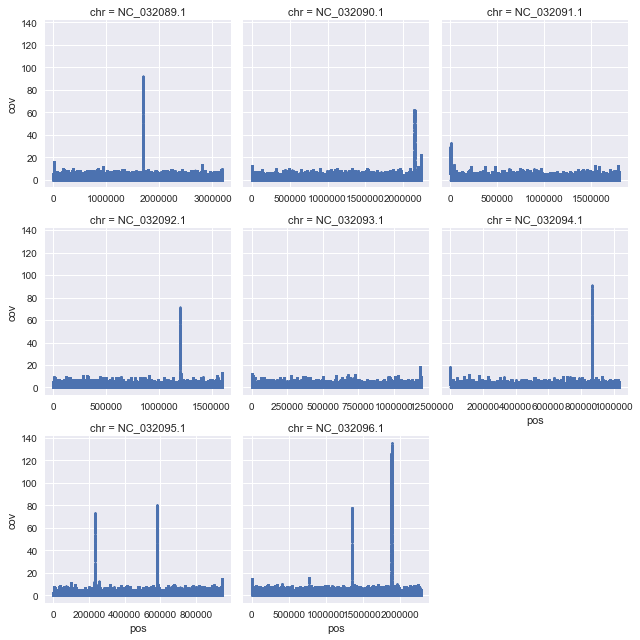

In [30]:
g = sns.FacetGrid(cov_genome, col='chr', col_wrap=3, sharex=False)
_ = g.map(plt.plot, 'pos', 'cov', marker='o', ms=2, ls='None')

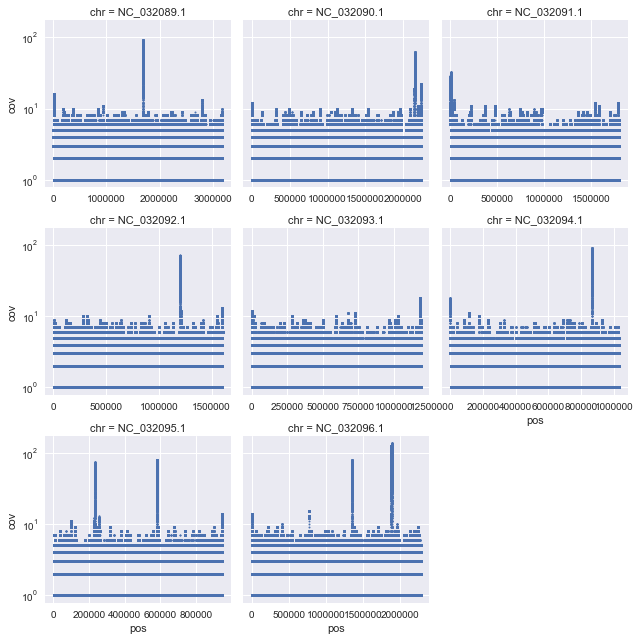

In [29]:
g = sns.FacetGrid(cov_genome, col='chr', col_wrap=3, sharex=False)
_ = g.map(plt.plot, 'pos', 'cov', marker='o', ms=2, ls='None')
_ = g.set(yscale='log')

Distribution of coverage values

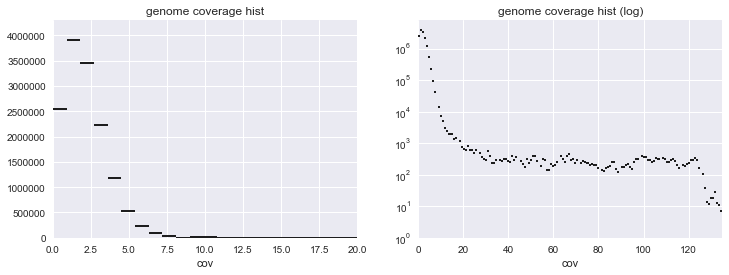

In [190]:
hist, bin_edges = np.histogram(cov_genome['cov'], bins=150)
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
_ = axs[0].hlines(hist, bin_edges[:-1], bin_edges[1:])
_ = axs[0].set(title='genome coverage hist', xlabel='cov', xlim=[bin_edges[0], 20], ylim=[0, hist.max()*1.1])
_ = axs[1].hlines(hist, bin_edges[:-1], bin_edges[1:])
_ = axs[1].set(title='genome coverage hist (log)', xlabel='cov', xlim=[bin_edges[0], bin_edges[-1]], ylim=[1, hist.max()*2], yscale='log')

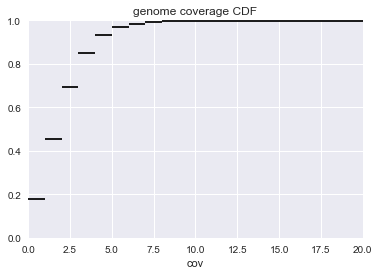

In [197]:
hist, bin_edges = np.histogram(cov_genome['cov'], bins=range(200))
cdf = np.cumsum(hist) / hist.sum()
fig, ax = plt.subplots()
_ = ax.hlines(cdf, bin_edges[:-1], bin_edges[1:])
_ = ax.set(title='genome coverage CDF', xlabel='cov', xlim=[bin_edges[0], 20], ylim=[0, 1])

Percentiles

In [464]:
nonzero = cov_genome['cov'] > 0
pct90 = sp.stats.scoreatpercentile(cov_genome['cov'][nonzero], 90)
pct80 = sp.stats.scoreatpercentile(cov_genome['cov'][nonzero], 80)
pct20 = sp.stats.scoreatpercentile(cov_genome['cov'][nonzero], 20)
pct10 = sp.stats.scoreatpercentile(cov_genome['cov'][nonzero], 10)

In [465]:
pct10, pct20, pct80, pct90

(1.0, 1.0, 3.0, 4.0)

Cover middle 80% of unique clones with how many logs of frequency?

In [466]:
np.log10(pct90) - np.log10(pct10)

0.6020599913279624

Cover middle 60% of unique clones with how many logs of frequency?

In [467]:
np.log10(pct80) - np.log10(pct20)

0.47712125471966244

### Read-weighted genome coverage

These coverage figures are for read-weighted coverage values.

In [209]:
cov_genome = cov_genome_weighted

Coverage along genome

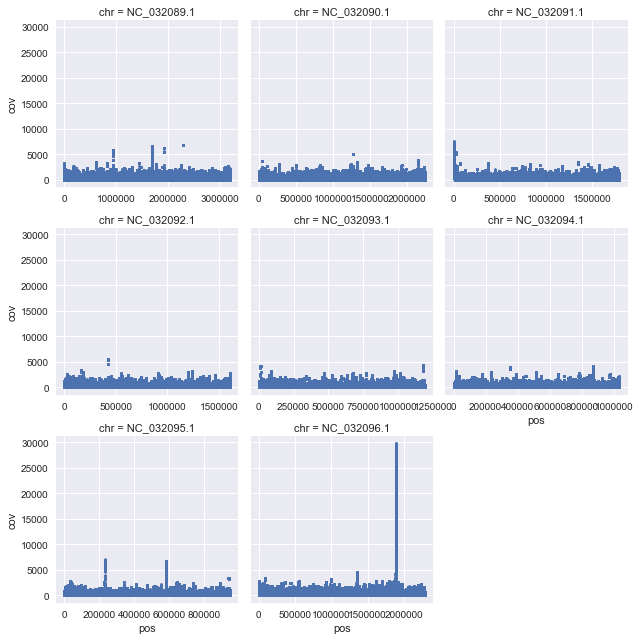

In [210]:
g = sns.FacetGrid(cov_genome, col='chr', col_wrap=3, sharex=False)
_ = g.map(plt.plot, 'pos', 'cov', marker='o', ms=2, ls='None')

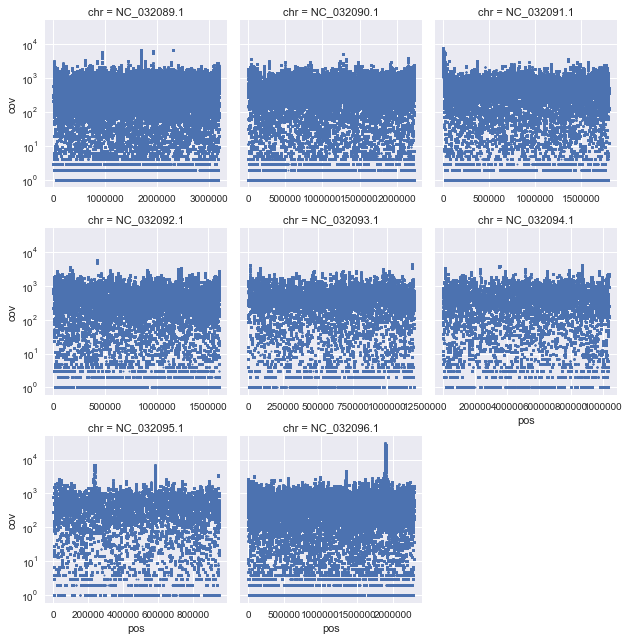

In [211]:
g = sns.FacetGrid(cov_genome, col='chr', col_wrap=3, sharex=False)
_ = g.map(plt.plot, 'pos', 'cov', marker='o', ms=2, ls='None')
_ = g.set(yscale='log')

Distribution of coverage values

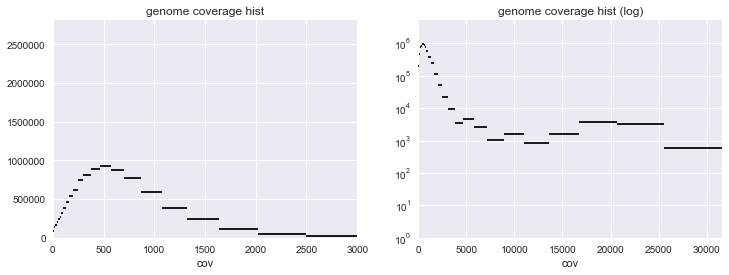

In [242]:
hist, bin_edges = np.histogram(cov_genome['cov'], bins=np.insert(np.logspace(0, 4.5), 0, 0))
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
_ = axs[0].hlines(hist, bin_edges[:-1], bin_edges[1:])
_ = axs[0].set(title='genome coverage hist', xlabel='cov', xlim=[bin_edges[0], 3000], ylim=[0, hist.max()*1.1])
_ = axs[1].hlines(hist, bin_edges[:-1], bin_edges[1:])
_ = axs[1].set(title='genome coverage hist (log)', xlabel='cov', xlim=[bin_edges[0], bin_edges[-1]], ylim=[1, hist.max()*2], yscale='log')

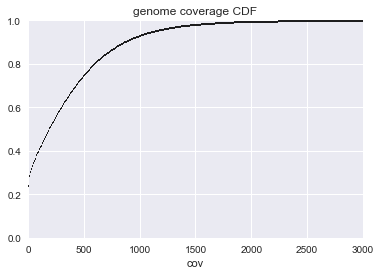

In [246]:
hist, bin_edges = np.histogram(cov_genome['cov'], bins='auto')
cdf = np.cumsum(hist) / hist.sum()
fig, ax = plt.subplots()
_ = ax.hlines(cdf, bin_edges[:-1], bin_edges[1:])
_ = ax.set(title='genome coverage CDF', xlabel='cov', xlim=[bin_edges[0], 3000], ylim=[0, 1])

Percentiles

In [247]:
pct90 = sp.stats.scoreatpercentile(cov_genome['cov'][nonzero], 90)
pct80 = sp.stats.scoreatpercentile(cov_genome['cov'][nonzero], 80)
pct20 = sp.stats.scoreatpercentile(cov_genome['cov'][nonzero], 20)
pct10 = sp.stats.scoreatpercentile(cov_genome['cov'][nonzero], 10)

In [248]:
pct10, pct20, pct80, pct90

(9.0, 51.0, 681.0, 951.0)

Cover middle 80% of unique clones with how many logs of frequency?

In [249]:
np.log10(pct90) - np.log10(pct10)

2.0239380074980891

Cover middle 60% of unique clones with how many logs of frequency?

In [250]:
np.log10(pct80) - np.log10(pct20)

1.1255769358148489

## CDS coverage

Load the data

In [267]:
names=['chr', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute', 'num_reads', 'num_cov_bases', 'len', 'frac_bases_cov']

cov_unstranded_weighted = pd.read_csv(cov_unstranded_weighted_file, sep='\t', header=None, names=names)
cov_unstranded_dedup = pd.read_csv(cov_unstranded_dedup_file, sep='\t', header=None, names=names)

cov_stranded_weighted = pd.read_csv(cov_stranded_weighted_file, sep='\t', header=None, names=names)
cov_stranded_dedup = pd.read_csv(cov_stranded_dedup_file, sep='\t', header=None, names=names)

cov_inframe_weighted = pd.read_csv(cov_inframe_weighted_file, sep='\t', header=None, names=names)
cov_inframe_dedup = pd.read_csv(cov_inframe_dedup_file, sep='\t', header=None, names=names)

Total number of coding bases

In [258]:
cov_inframe_dedup['len'].sum()

8955545

Fraction of genome that is coding

In [260]:
cov_inframe_dedup['len'].sum() / len(cov_genome_dedup)

0.62702194394239841

Number of CDSs

In [262]:
len(cov_inframe_dedup)

6432

Number of CDSs with inframe coverage

In [263]:
np.sum(cov_inframe_dedup['num_cov_bases'] > 0)

3813

Fraction of CDSs with inframe coverage

In [265]:
np.sum(cov_inframe_dedup['num_cov_bases'] > 0) / len(cov_inframe_dedup)

0.59281716417910446

Fraction coding bases covered

In [266]:
cov_inframe_dedup['num_cov_bases'].sum() / cov_inframe_dedup['len'].sum()

0.25495455608787626

Unstranded vs stranded vs inframe clone coverage (dedup'd)

We expect that half the unstranded clones will be stranded, and one third the stranded clones will be inframe. The black lines represent the expected relationships.

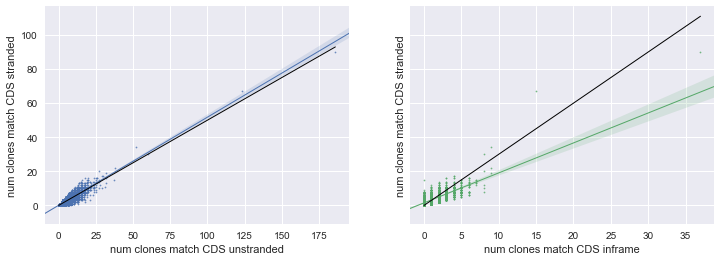

In [323]:
joined1 = pd.merge(cov_unstranded_dedup, cov_stranded_dedup, on=['chr', 'start', 'end'], suffixes=['_unstranded', '_stranded'])
x = np.linspace(0, joined1['num_reads_unstranded'].max())
y = x / 2
joined2 = pd.merge(cov_stranded_dedup, cov_inframe_dedup, on=['chr', 'start', 'end'], suffixes=['_stranded', '_inframe'])
z = np.linspace(0, joined2['num_reads_inframe'].max())
w = z * 3

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
_ = sns.regplot('num_reads_unstranded', 'num_reads_stranded', data=joined1, ax=ax[0], scatter_kws={'s': 3}, line_kws={'lw': 1})
_ = ax[0].plot(x, y, color='k', lw=1)
_ = ax[0].set(xlabel='num clones match CDS unstranded', ylabel='num clones match CDS stranded')
_ = sns.regplot('num_reads_inframe', 'num_reads_stranded', data=joined2, ax=ax[1], scatter_kws={'s': 3}, line_kws={'lw': 1})
_ = ax[1].plot(z, w, color='k', lw=1)
_ = ax[1].set(xlabel='num clones match CDS inframe', ylabel='num clones match CDS stranded')

Read-weighted vs dedup'd CDS coverage

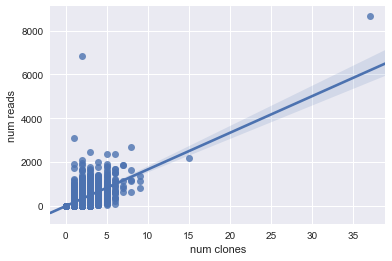

In [324]:
joined = pd.merge(cov_inframe_dedup, cov_inframe_weighted, on=['chr', 'start', 'end'], suffixes=['_dedup', '_weighted'])
fig, ax = plt.subplots()
_ = sns.regplot('num_reads_dedup', 'num_reads_weighted', data=joined, ax=ax)
_ = ax.set(xlabel='num clones', ylabel='num reads')

Distribution of gene coverage fractions

For each gene, compute histogram of its coverage fraction.  Only compute over genes that have non-zero coverage.

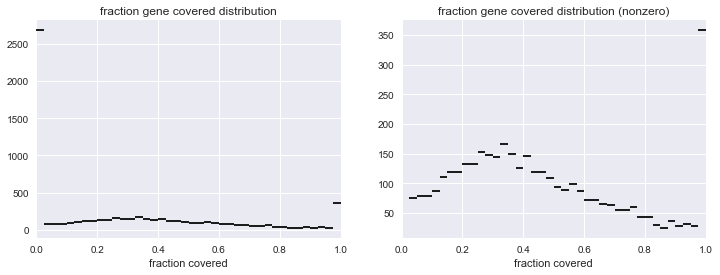

In [309]:
hist, bin_edges = np.histogram(cov_inframe_dedup['frac_bases_cov'], bins=40)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
_ = ax[0].hlines(hist, bin_edges[:-1], bin_edges[1:])
_ = ax[0].set(title='fraction gene covered distribution', xlabel='fraction covered', xlim=[0, 1])
_ = ax[1].hlines(hist[1:], bin_edges[1:-1], bin_edges[2:])
_ = ax[1].set(title='fraction gene covered distribution (nonzero)', xlabel='fraction covered', xlim=[0, 1])

Distribution of number of clones that overlaps each gene inframe

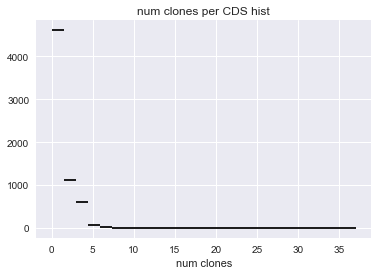

In [333]:
hist, bin_edges = np.histogram(cov_inframe_dedup['num_reads'], bins=25)
fig, ax = plt.subplots()
_ = ax.hlines(hist, bin_edges[:-1], bin_edges[1:])
_ = ax.set(title='num clones per CDS hist', xlabel='num clones')

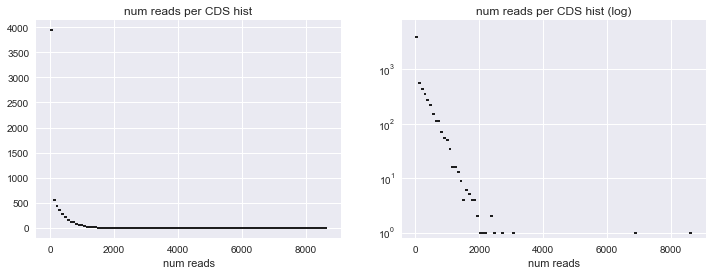

In [348]:
hist, bin_edges = np.histogram(cov_inframe_weighted['num_reads'], bins=100)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
_ = ax[0].hlines(hist, bin_edges[:-1], bin_edges[1:])
_ = ax[0].set(title='num reads per CDS hist', xlabel='num reads')
_ = ax[1].hlines(hist, bin_edges[:-1], bin_edges[1:])
_ = ax[1].set(title='num reads per CDS hist (log)', xlabel='num reads', yscale='log', ylim=[8e-1, hist.max()*2])

[(0, 1),
 (0.0, 8658.0),
 Text(0.5,0,'num reads (coverage)'),
 Text(0.5,1,'CDS read-weighted coverage CDF')]

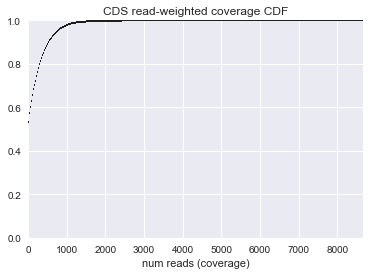

In [354]:
hist, bin_edges = np.histogram(cov_inframe_weighted['num_reads'], bins='auto')
cdf = np.cumsum(hist) / hist.sum()
fig, ax = plt.subplots()
ax.hlines(cdf, bin_edges[:-1], bin_edges[1:])
ax.set(title='CDS read-weighted coverage CDF', xlabel='num reads (coverage)', xlim=[bin_edges[0], bin_edges[-1]], ylim=[0, 1])

## Clone analysis

In [356]:
fragments = pd.read_csv(fragment_file, sep='\t', header=0)

Number of observed clones

In [358]:
len(fragments)

47260

Number of observed clones with overlap

In [387]:
(fragments.has_overlap == 1).sum()

19322

Number of observed clones with inframe overlap

In [388]:
(fragments.has_inframe_overlap == 1).sum()

4226

Rough fraction of clones expected to be coding (lower bound)

In [360]:
cov_inframe_dedup['len'].sum() / len(cov_genome_dedup) / 6

0.10450365732373307

Observed fraction of clones that code for an annotated CDS

In [362]:
(fragments.has_inframe_overlap == 1).sum() / len(fragments)

0.089420228523063902

Observed fraction of "particles" (reads) that code for an annotated CDS

In [460]:
fragments[fragments.has_inframe_overlap == 1]['count'].sum() / fragments['count'].sum()

0.083350461296344991

Distribution of fragment lengths

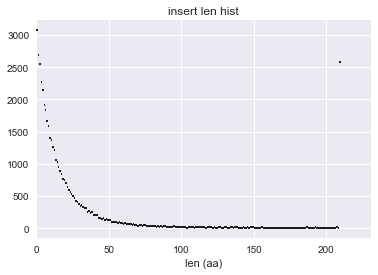

In [385]:
hist, bin_edges = np.histogram(fragments.fragment_aa.str.len().fillna(0), bins=211)
fig, ax = plt.subplots()
_ = ax.hlines(hist, bin_edges[:-1], bin_edges[1:])
_ = ax.set(title='insert len hist', xlabel='len (aa)', xlim=[bin_edges[0], bin_edges[-1] * 1.1])

Distribution of clone sizes

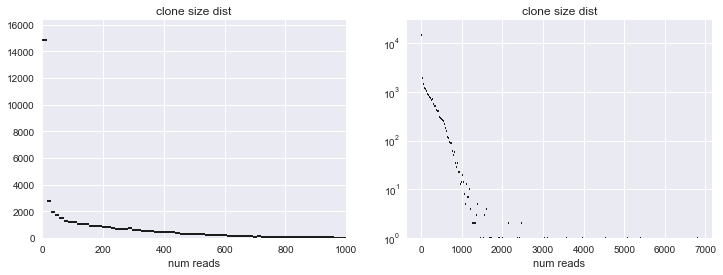

In [400]:
hist, bin_edges = np.histogram(fragments['count'], bins='auto')
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
_ = ax[0].hlines(hist, bin_edges[:-1], bin_edges[1:])
_ = ax[0].set(title='clone size dist', xlabel='num reads', xlim=[0, 1000], ylim=[0, hist.max() * 1.1])
_ = ax[1].hlines(hist, bin_edges[:-1], bin_edges[1:])
_ = ax[1].set(title='clone size dist', xlabel='num reads', yscale='log', ylim=[1, hist.max() * 2])

[(0, 1), (1.0, 6811.0), Text(0.5,0,'num reads'), Text(0.5,1,'clone size CDF')]

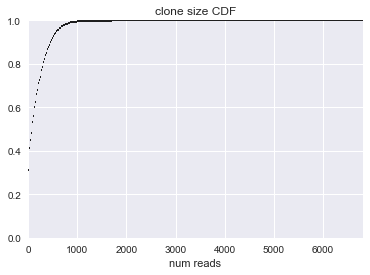

In [404]:
hist, bin_edges = np.histogram(fragments['count'], bins='auto')
cdf = np.cumsum(hist) / hist.sum()

fig, ax = plt.subplots()
ax.hlines(cdf, bin_edges[:-1], bin_edges[1:])
ax.set(title='clone size CDF', xlabel='num reads', xlim=[bin_edges[0], bin_edges[-1]], ylim=[0, 1])

Distribution of INFRAME clone sizes

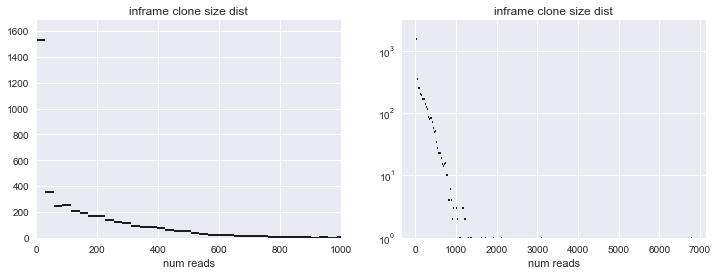

In [407]:
hist, bin_edges = np.histogram(fragments[fragments.has_inframe_overlap == 1]['count'], bins='auto')
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
_ = ax[0].hlines(hist, bin_edges[:-1], bin_edges[1:])
_ = ax[0].set(title='inframe clone size dist', xlabel='num reads', xlim=[0, 1000], ylim=[0, hist.max() * 1.1])
_ = ax[1].hlines(hist, bin_edges[:-1], bin_edges[1:])
_ = ax[1].set(title='inframe clone size dist', xlabel='num reads', yscale='log', ylim=[1, hist.max() * 2])

[(0, 1),
 (1.0, 6811.0),
 Text(0.5,0,'num reads'),
 Text(0.5,1,'inframe clone size CDF')]

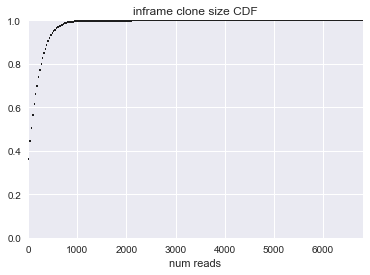

In [408]:
hist, bin_edges = np.histogram(fragments[fragments.has_inframe_overlap == 1]['count'], bins='auto')
cdf = np.cumsum(hist) / hist.sum()

fig, ax = plt.subplots()
ax.hlines(cdf, bin_edges[:-1], bin_edges[1:])
ax.set(title='inframe clone size CDF', xlabel='num reads', xlim=[bin_edges[0], bin_edges[-1]], ylim=[0, 1])

Is there a relationship between the observed count and the amount of protein that's coded for?

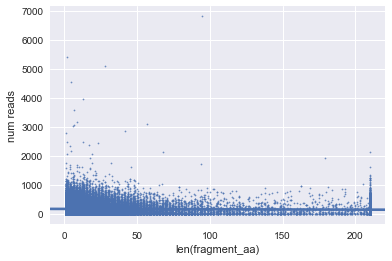

In [373]:
fig, ax = plt.subplots()
sns.regplot(fragments.fragment_aa.str.len(), fragments['count'], scatter_kws={'s': 3})
_ = ax.set(xlabel='len(fragment_aa)', ylabel='num reads')

Does GC content affect the count?

In [414]:
def gc_content(seq):
    s = seq.upper()
    gs = s.count('G')
    cs = s.count('C')
    as_ = s.count('A')
    ts = s.count('T')
    return (gs + cs) / (gs + cs + as_ + ts)

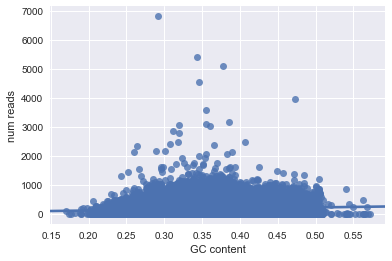

In [417]:
fig, ax = plt.subplots()
_ = sns.regplot(fragments.fragment_nt.apply(gc_content), fragments['count'])
_ = ax.set(xlabel='GC content', ylabel='num reads')

Most common clones

In [439]:
fragments.sort_values('count', ascending=False).head()

,chr,position,strand,count,has_overlap,has_inframe_overlap,bases_till_overlap,fragment_nt,fragment_aa,annot
4543,NC_032089.1,2293142,-,6811,1,1,0.0,ACCTATTTGATGTTAATGTTGAATGCAAAAGTACCAAAAGATTTAC...,TYLMLMLNAKVPKDLLRPSRPFTELVVSFSLLCGGLIFMELTDPVI...,ID=cds961;Parent=rna997;Dbxref=CGD:CAL00001890...
3241,NC_032089.1,1918943,+,5413,0,0,NaN,GTCGTATGATCTTTCGGTTTGcctattattattattattataccTG...,VV,.
19897,NC_032091.1,27661,+,5089,1,0,616.0,AATATTTCTGGGGTACTACGTCATTGGACAATAACCACGGAATTTA...,NISGVLRHWTITTEFRVYDIIANPVCIE,ID=cds2367;Parent=rna2458;Dbxref=CGD:CAL000019...
25695,NC_032092.1,425724,+,4541,0,0,NaN,GCTTTGAGGATCCTTTAGATTCAGTGTCAAATACAGCTGCTGACAG...,ALRIL,.
42621,NC_032096.1,1893151,-,3963,0,0,NaN,GTAATAATCTGGTGTGACAAgttgataaaaaattggttgTAAGTTT...,VIIWCDKLIKNWL,.


Most common INFRAME clones

In [441]:
fragments[fragments.has_inframe_overlap == 1].sort_values('count', ascending=False).head()

,chr,position,strand,count,has_overlap,has_inframe_overlap,bases_till_overlap,fragment_nt,fragment_aa,annot
4543,NC_032089.1,2293142,-,6811,1,1,0.0,ACCTATTTGATGTTAATGTTGAATGCAAAAGTACCAAAAGATTTAC...,TYLMLMLNAKVPKDLLRPSRPFTELVVSFSLLCGGLIFMELTDPVI...,ID=cds961;Parent=rna997;Dbxref=CGD:CAL00001890...
38112,NC_032095.1,942192,-,3111,1,1,0.0,CTAAAATTGGACGACAAAGTACATGCCACCACAGACAACAACTTGG...,LKLDDKVHATTDNNLDMNNILENDELILDGLNMTLLDNGDHANEEF...,ID=cds5066;Parent=rna5241;Dbxref=CGD:CAL000018...
40399,NC_032096.1,1613176,+,2138,1,1,0.0,CCAGTACAAGCTGAACAACcgcaaccacaaccacaaccacatcaac...,PVQAEQPQPQPQPHQQQHQQQQHQPELQNTYQQIKHIQQQQQMLQH...,ID=cds5732;Parent=rna5946;Dbxref=CGD:CAL000019...
10013,NC_032090.1,1030542,-,1922,1,1,0.0,aaagttggtagaagaagaattttatTGGTAGGAATGCCATGCATGT...,KVGRRRILLVGMPCMCISLIVCAVAFHYLNVDFSTGTVVSRGINGW...,ID=cds1808;Parent=rna1875;Dbxref=CGD:CAL000020...
37087,NC_032095.1,655887,+,1723,1,1,0.0,CATTTCTCCAATTATATGTCACAGCAATTGACTAACCCATCAACTA...,HFSNYMSQQLTNPSTTPNHEHEDELETSSEDDEDEEEYIDPNDDGR...,ID=cds4942;Parent=rna5116;Dbxref=CGD:CAL000018...


Genes from most common clones

In [452]:
for s in fragments[fragments.has_inframe_overlap == 1].sort_values('count', ascending=False).head()['annot']:
    for f in s.split(';'):
        print(f)
    print()

ID=cds961
Parent=rna997
Dbxref=CGD:CAL0000189087,GeneID:3634836,Genbank:XP_723589.2
Name=XP_723589.2
Note=Putative protein of unknown function%3B Hap43p-repressed gene%3B increased transcription is observed upon fluphenazine treatment%3B possibly transcriptionally regulated by Tac1p%3B induced by nitric oxide%3B fungal-specific (no human/murine homolog
gbkey=CDS
orig_transcript_id=gnl|WGS:AACQ|mrna_CAALFM_C110360CA
product=hypothetical protein
protein_id=XP_723589.2
transl_table=12

ID=cds5066
Parent=rna5241
Dbxref=CGD:CAL0000186660,GeneID:30515361,Genbank:XP_019331044.1
Name=XP_019331044.1
Note=Putative protein of unknown function%2C transcript is upregulated in an RHE model of oral candidiasis
gbkey=CDS
orig_transcript_id=gnl|WGS:AACQ|mrna_CAALFM_C704340CA
product=hypothetical protein
protein_id=XP_019331044.1
transl_table=12

ID=cds5732
Parent=rna5946
Dbxref=CGD:CAL0000191878,GeneID:3646034,Genbank:XP_712331.2
Name=XP_712331.2
Note=Transcription factor%3B similar to S. cerevisiae Ac

### Diversity

Observed clones

In [418]:
len(fragments)

47260

Observed inframe clones

In [419]:
(fragments.has_inframe_overlap == 1).sum()

4226

Chao1

In [426]:
skbio.diversity.alpha_diversity('chao1', fragments['count'])[0]

54189.258676538637

Chao1 inframe

In [437]:
skbio.diversity.alpha_diversity('chao1', fragments[fragments.has_inframe_overlap == 1]['count'].values)[0]

4815.1676300578038

Shannon entropy effective population size

In [455]:
2 ** skbio.diversity.alpha_diversity('shannon', fragments['count'])[0]

23396.596407037236

Shannon entropy INFRAME effective population size

In [457]:
2 ** skbio.diversity.alpha_diversity('shannon', fragments[fragments.has_inframe_overlap == 1]['count'].values)[0]

2097.3718374149526

In [47]:
def parse_recon_fitfile(path):
    with open(path, 'r') as ip:
        lines = [line.strip() for line in ip.readlines()]
    lines.reverse()
    line = lines.pop()
    while not line.startswith('observed_clone_size_distribution'):
        line = lines.pop()
    observed_clone_size_distribution = eval(line.split('=')[-1])
    start = lines.index('===========================================')
    n0 = float(lines[start + 4].split('=')[-1].strip())
    parameters = eval(lines[start + 5].split('=')[-1])
    weights = parameters[:len(parameters) // 2]
    means = parameters[len(parameters) // 2:]
    return {'observed_clone_size_distribution': observed_clone_size_distribution,
            'n0': n0,
            'weights': weights,
            'means': means}

In [48]:
# recon_allreads_results = parse_recon_fitfile(recon_allreads_path)

In [49]:
# sum(recon_allreads_results['observed_clone_size_distribution'].values())